# Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

### The best I could do...

Together with Alberto Vecchio and Geraint Prattent, I tackled this classification problem with neural networks: [arXiv:2007.06585](https://arxiv.org/abs/2007.06585). Next time we look into deep learning.

In the paper we reached an accuracy (true positive + true negative / total) of $98.4\%$. The data you're using are those of the green curve in Fig 2 of that paper. Could you do better? If yes, please tell me how!

I should have really put a figure with my ROC in that paper but I didn't! Deep learning people liked the accuracy and I just went with the flow.


### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find!

In [1]:
import h5py
import emcee
import corner
import numpy as np
from scipy import stats
from astropy.table import Table
import pandas as pd
import tqdm as tqdm

from astroML.utils import completeness_contamination
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.classification import GMMBayes
from astroML.resample import bootstrap

import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.decomposition import PCA
    
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Fetching the data

In [2]:
data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
data.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

#### Downsample the data

In [4]:
X = []
n_data = 20000
for label in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']:
    X.append(data[label][:n_data])

X = np.array(X).T
y = np.array(data['det'][:n_data])

### Visualize the data: Corner plot

In [5]:
%%capture
# labels = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 
#          'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']

labels = [r"$\chi_{1, x}$", r"$\chi_{1, y}$", r"$\chi_{1, z}$", r"$\chi_{2, x}$", 
                           r"$\chi_{2, y}$", r"$\chi_{2, z}$", r"dec", r"iota", r"$m_{tot}$", r"$\Psi$", 
                           r"$q$", r"ra", r"$z$"]

# Creazione del corner plot
figure = corner.corner(X, labels=labels, quantiles=[0.05, 0.5, 0.95], show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": 10}, figsize=(10, 6))

#### Marginalized 1D-distributions

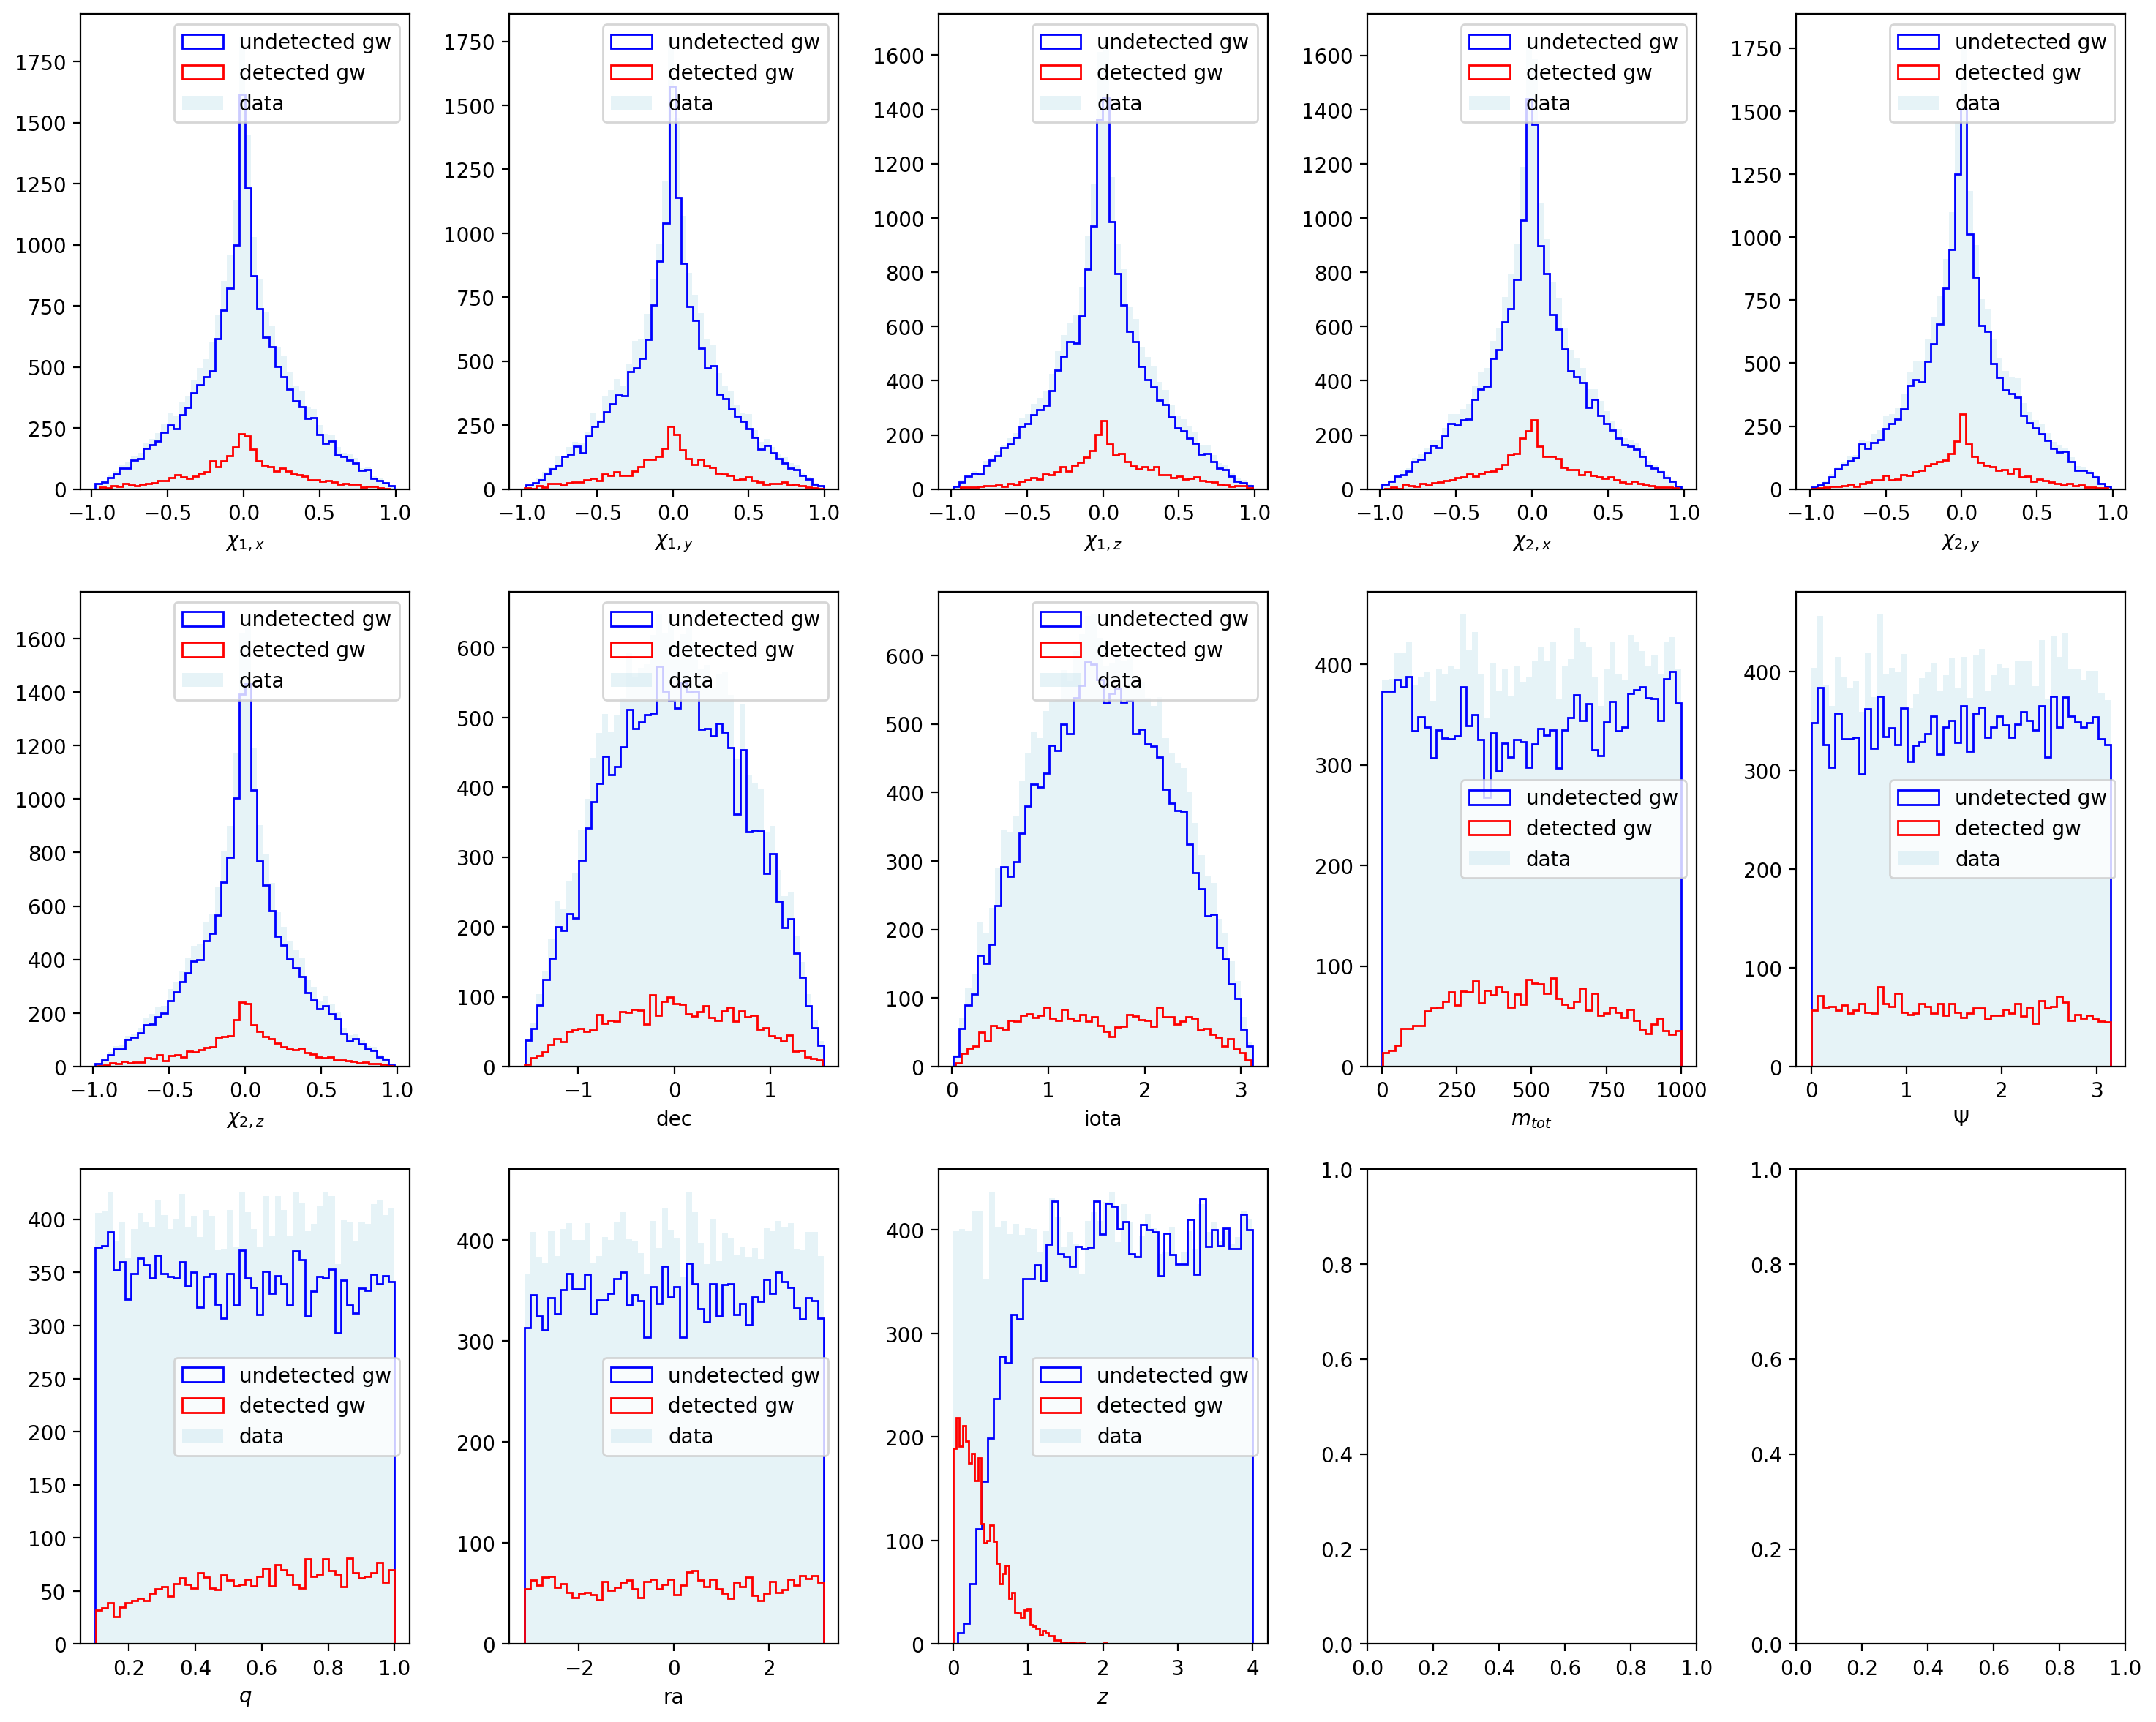

In [6]:
fig, axs = plt.subplots(3, 5, figsize=(15, 12))

labels=[r"$\chi_{1, x}$", r"$\chi_{1, y}$", r"$\chi_{1, z}$", r"$\chi_{2, x}$", 
                           r"$\chi_{2, y}$", r"$\chi_{2, z}$", r"dec", r"iota", r"$m_{tot}$", r"$\Psi$", 
                           r"$q$", r"ra", r"$z$"]

for ax, data, xlabel in zip(axs.flatten(), X.T, labels):
    
    ax.hist(data[y==0], bins=50, color='blue', histtype = 'step', label = 'undetected gw', lw=1)
    ax.hist(data[y==1], bins=50, color='red',histtype = 'step', label = 'detected gw', lw=1)
    ax.hist(data, bins=50, label = 'data', color='lightblue', alpha=0.3)
    ax.legend()
    ax.set_xlabel(xlabel)
    
plt.tight_layout(pad=1.5);

In [7]:
from collections import Counter
print(Counter(y))

Counter({0: 17123, 1: 2877})


In [8]:
import pandas as pd
df = pd.DataFrame(X, columns=labels)
print(df.describe())

       $\chi_{1, x}$  $\chi_{1, y}$  $\chi_{1, z}$  $\chi_{2, x}$  \
count   20000.000000   20000.000000   20000.000000   20000.000000   
mean       -0.001337      -0.002661       0.003230       0.002868   
std         0.335243       0.336493       0.332664       0.337044   
min        -0.974899      -0.982666      -0.986481      -0.982475   
25%        -0.186725      -0.193959      -0.185909      -0.183143   
50%         0.000207      -0.001076       0.000715      -0.000142   
75%         0.189634       0.186669       0.192126       0.192266   
max         0.994928       0.996236       0.984821       0.983828   

       $\chi_{2, y}$  $\chi_{2, z}$           dec          iota     $m_{tot}$  \
count   20000.000000   20000.000000  20000.000000  20000.000000  20000.000000   
mean       -0.000787      -0.004854      0.002010      1.569710    504.109749   
std         0.334616       0.332434      0.683077      0.684733    288.659178   
min        -0.993680      -0.985935     -1.557333     

### Scaling the results

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Splitting the dataset in training and validation set

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [12]:
# Model initialization
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:,1]


In [13]:
# Valutazione
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_prob))

# Matrice di confusione
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5137
           1       0.91      0.81      0.86       863

    accuracy                           0.96      6000
   macro avg       0.94      0.90      0.92      6000
weighted avg       0.96      0.96      0.96      6000

ROC AUC Score: 0.9905072620849218
Confusion Matrix:
[[5068   69]
 [ 167  696]]


In [14]:
from astroML.utils import completeness_contamination

In [15]:
completeness, contamination = completeness_contamination(y_pred, y_val)
print('Completeness: ', completeness)
print('Contamination: ', contamination)

Completeness:  0.8064889918887601
Contamination:  0.09019607843137255


### Find the best depth

In [16]:
depth     = np.arange(1, 20)
rms_train  = np.zeros(len(depth))
rms_val   = np.zeros(len(depth))

best_index = 0
y_best_fit = None

for i, d in tqdm.tqdm(enumerate(depth)):

    clf = RandomForestClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)

    y_fit_train = clf.predict(X_train)
    y_fit = clf.predict(X_val)
    rms_train[i] = np.mean(np.sqrt((y_fit_train-y_train)**2))
    rms_val[i]   = np.mean(np.sqrt((y_val-y_fit)**2))

    if rms_val[i] <= rms_val[best_index]:
        best_index = i
        y_best_fit = y_fit

best_depth = depth[best_index]

19it [02:01,  6.39s/it]


In [17]:
print('Best Depths: ', best_depth)

Best Depths:  18


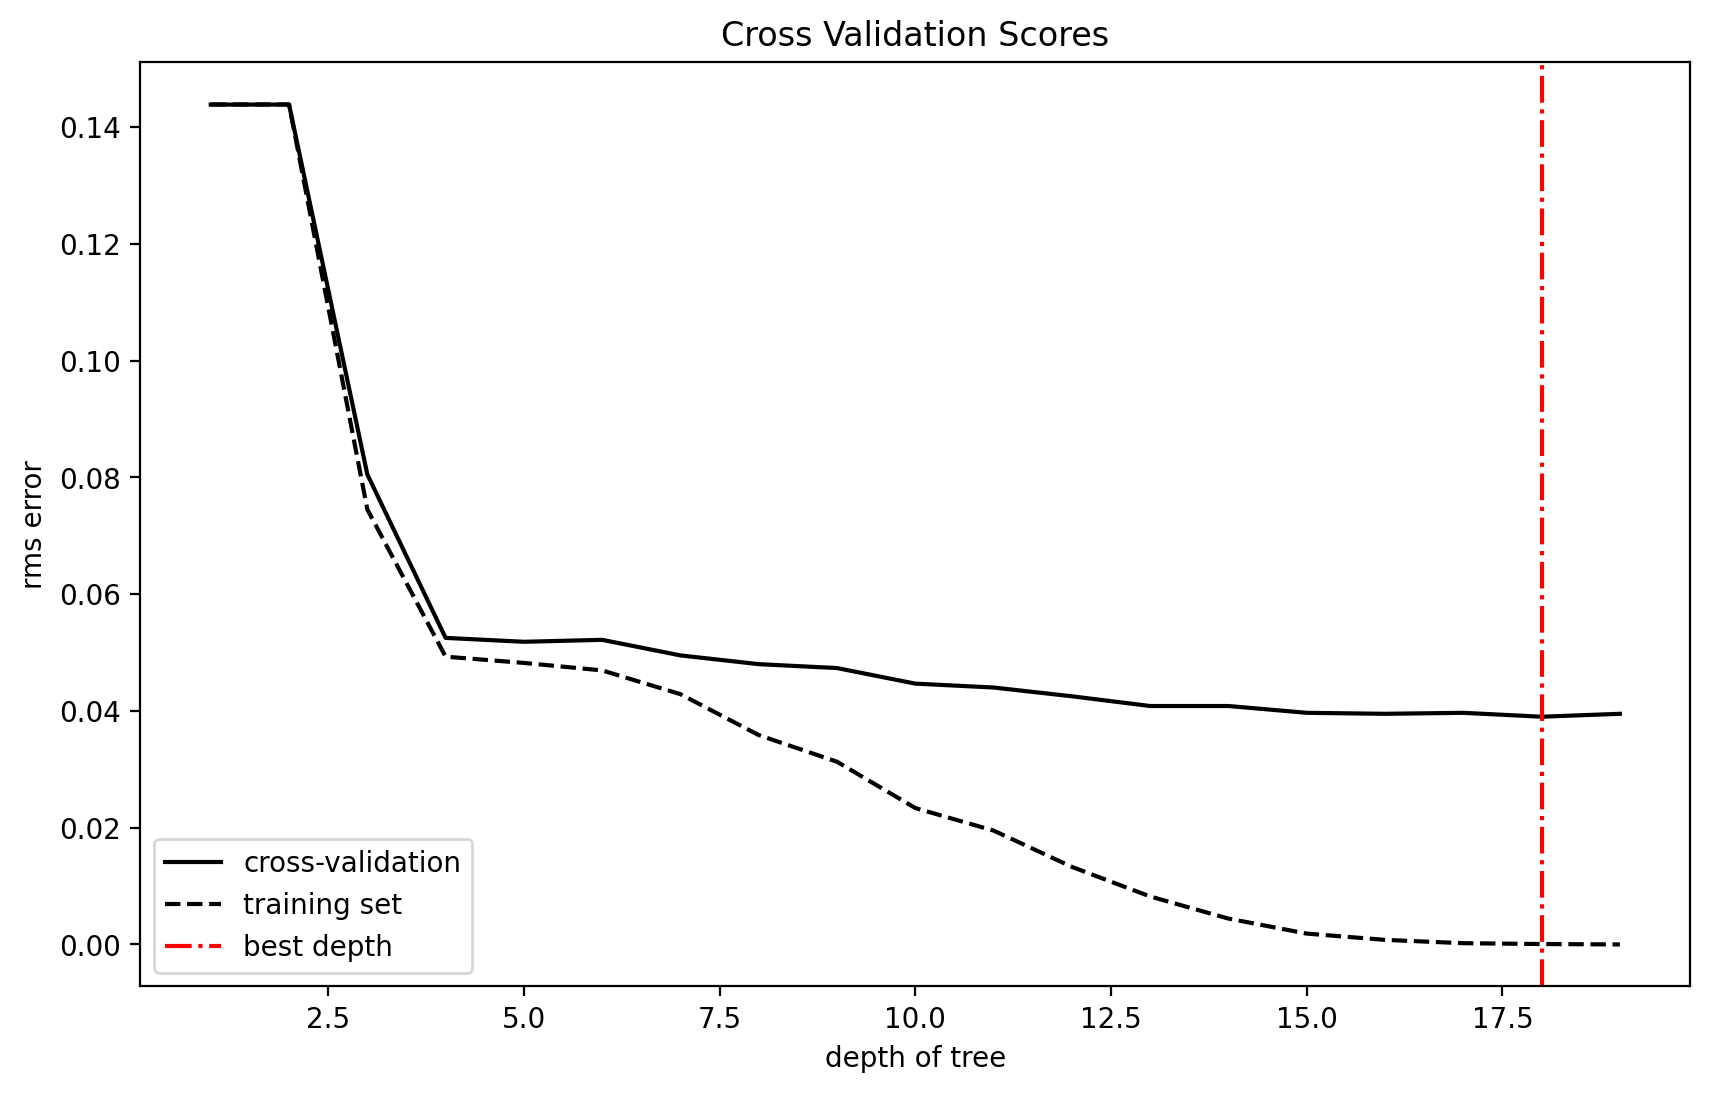

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(depth, rms_val, '-k', label='cross-validation')
plt.plot(depth, rms_train, '--k', label='training set')
plt.axvline(x=best_depth, c='red', linestyle='-.', label='best depth')
plt.xlabel('depth of tree')
plt.ylabel('rms error')
plt.title('Cross Validation Scores')

plt.legend(loc='lower left');

In [19]:
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_val)
y_prob = best_rf.predict_proba(X_val)[:,1]

In [20]:
completeness, contamination = completeness_contamination(y_pred, y_val)

print('Completeness:  ', completeness)
print('Contamination: ', contamination)

Completeness:   0.8053302433371958
Contamination:  0.09031413612565445


In [21]:
# Model Evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))
print('-----------------------------------------------------------')

print("ROC AUC Score:", roc_auc_score(y_val, y_prob))
print('-----------------------------------------------------------')

# Confusion Matrix
C_mat = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(C_mat)
print('-----------------------------------------------------------')

print(f'Guessed: {np.sum(C_mat.diagonal())/len(y_val) * 100} %')

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5137
           1       0.91      0.81      0.85       863

    accuracy                           0.96      6000
   macro avg       0.94      0.90      0.92      6000
weighted avg       0.96      0.96      0.96      6000

-----------------------------------------------------------
ROC AUC Score: 0.9899984909426105
-----------------------------------------------------------
Confusion Matrix:
[[5068   69]
 [ 168  695]]
-----------------------------------------------------------
Guessed: 96.05 %


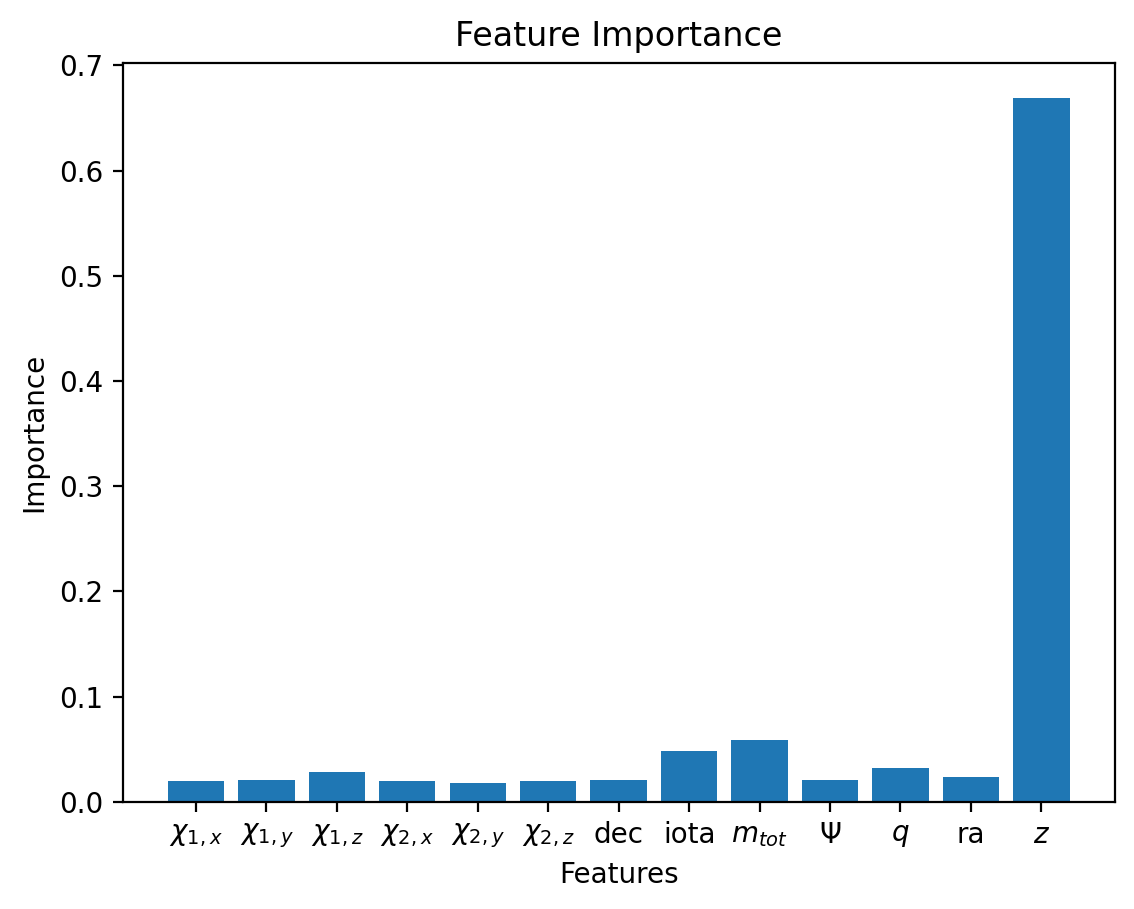

In [22]:
feature_importance = best_rf.feature_importances_
plt.bar(labels, feature_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

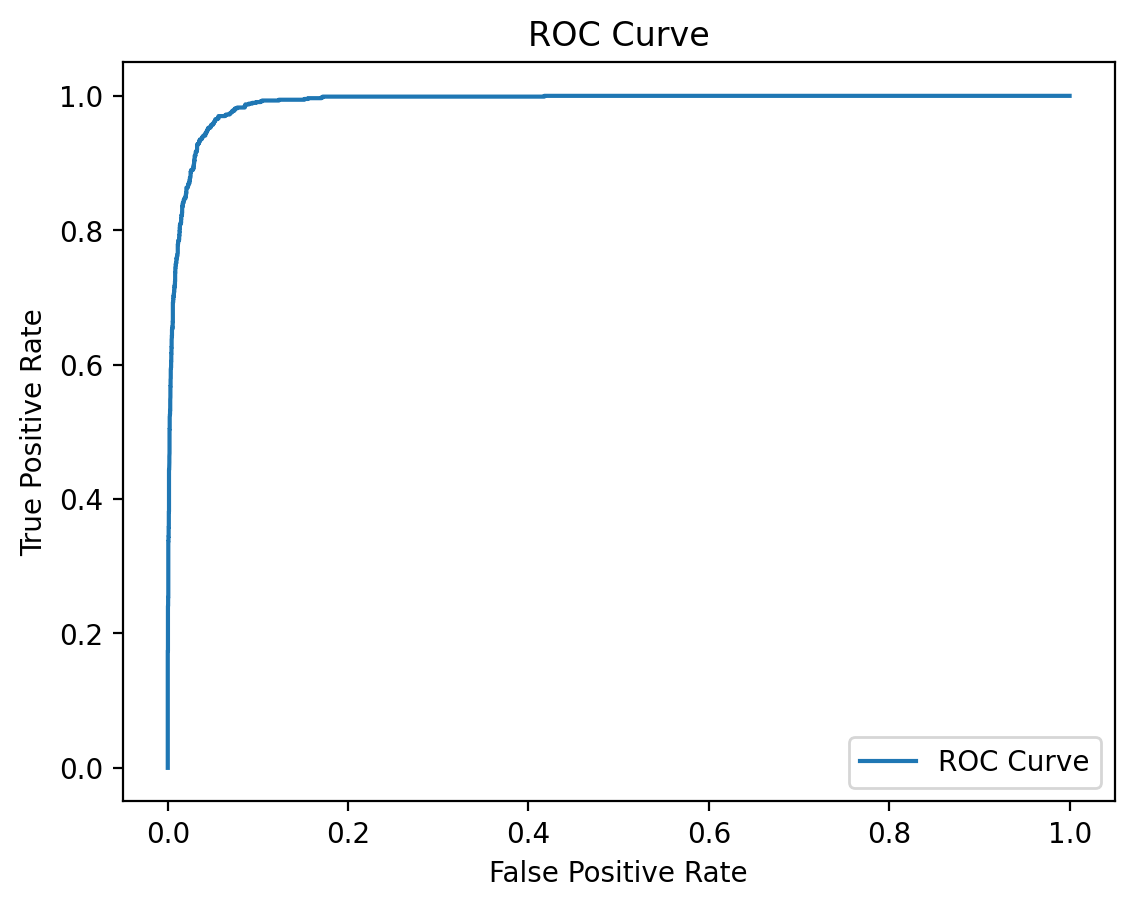

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.plot(fpr, tpr, label="ROC Curve")
#plt.ylim(0.8, 1.)
#plt.xlim(0, 0.04)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 2D Analysis: $m_{tot}$, $z$

In [30]:
data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [31]:
X_2d = []
n_data = 20000
for label in ['mtot', 'z']:
    X_2d.append(data[label][:n_data])

X_2d = np.array(X_2d).T
y_2d = np.array(data['det'][:n_data])

In [32]:
X_2d_scaled = scaler.fit_transform(X_2d)

In [33]:
X_train_2d, X_val_2d, y_train_2d, y_val_2d = train_test_split(X_2d_scaled, y_2d, test_size=0.3, random_state=42, stratify=y_2d)

In [34]:
rf2d = RandomForestClassifier(best_depth)
rf2d.fit(X_train_2d, y_train_2d)

y_pred_2d = rf2d.predict(X_val_2d)
y_prob_2d = rf2d.predict_proba(X_val_2d)[:,1]

In [35]:
completeness, contamination = completeness_contamination(y_pred_2d, y_val_2d)

print('Completeness:  ', completeness)
print('Contamination: ', contamination)

Completeness:   0.7207415990730012
Contamination:  0.1837270341207349


In [36]:
# Model Evaluation
print("Classification Report:")
print(classification_report(y_val_2d, y_pred_2d))
print('-----------------------------------------------------------')

print("ROC AUC Score:", roc_auc_score(y_val_2d, y_prob_2d))
print('-----------------------------------------------------------')

# Confusion Matrix
C_mat = confusion_matrix(y_val_2d, y_pred_2d)
print("Confusion Matrix:")
print(C_mat)
print('-----------------------------------------------------------')

print(f'Guessed: {np.sum(C_mat.diagonal())/len(y_val_2d) * 100} %')

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5137
           1       0.82      0.72      0.77       863

    accuracy                           0.94      6000
   macro avg       0.89      0.85      0.86      6000
weighted avg       0.93      0.94      0.93      6000

-----------------------------------------------------------
ROC AUC Score: 0.9543638714066558
-----------------------------------------------------------
Confusion Matrix:
[[4997  140]
 [ 241  622]]
-----------------------------------------------------------
Guessed: 93.65 %


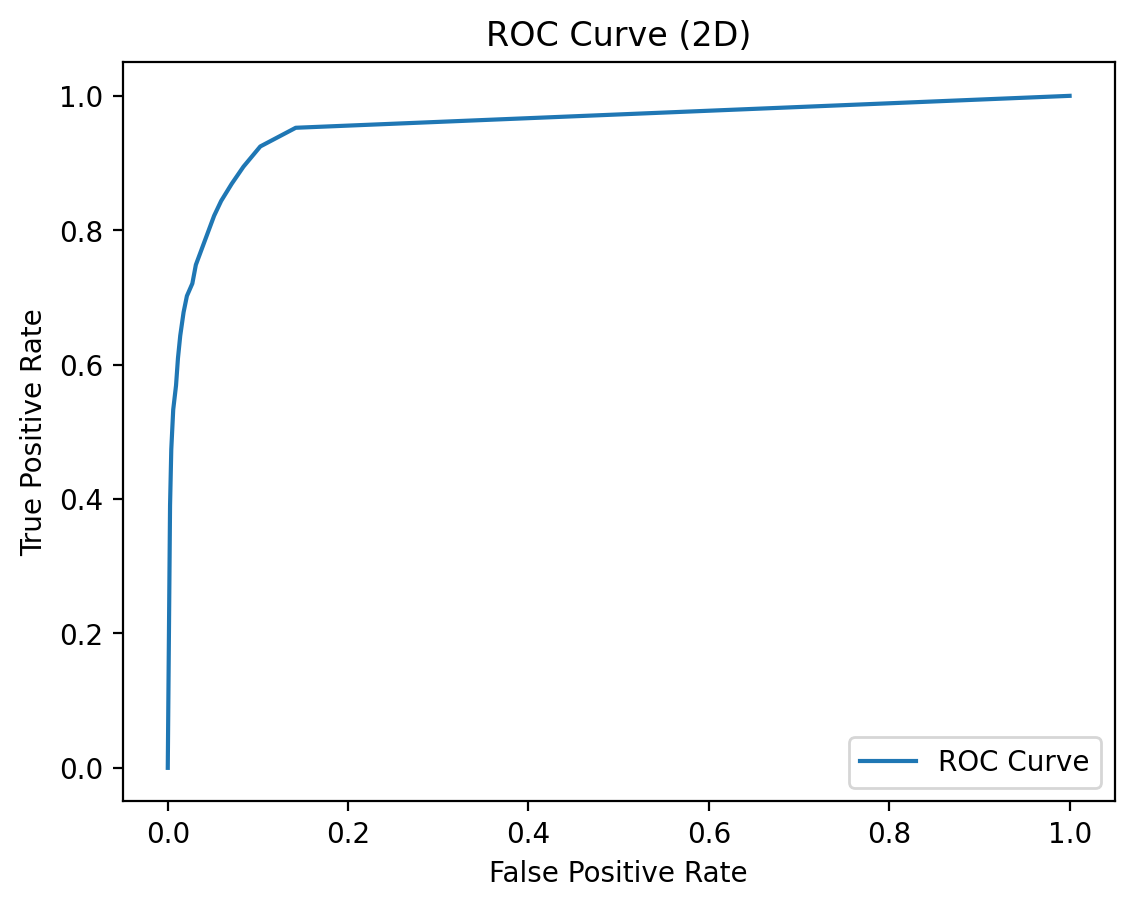

In [37]:
fpr, tpr, thresholds = roc_curve(y_val_2d, y_prob_2d)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (2D)")
plt.legend()
plt.show()

## PCA

In [38]:
n_features = 13

pca = PCA(n_components=n_features, whiten=True)
pca.fit(X)
evals = pca.explained_variance_ratio_

print(evals)

[9.99914767e-01 3.92464485e-05 1.60252312e-05 9.86035220e-06
 5.63336570e-06 5.58986842e-06 1.37757043e-06 1.35957742e-06
 1.35920638e-06 1.32868124e-06 1.32510109e-06 1.31602682e-06
 8.11761242e-07]


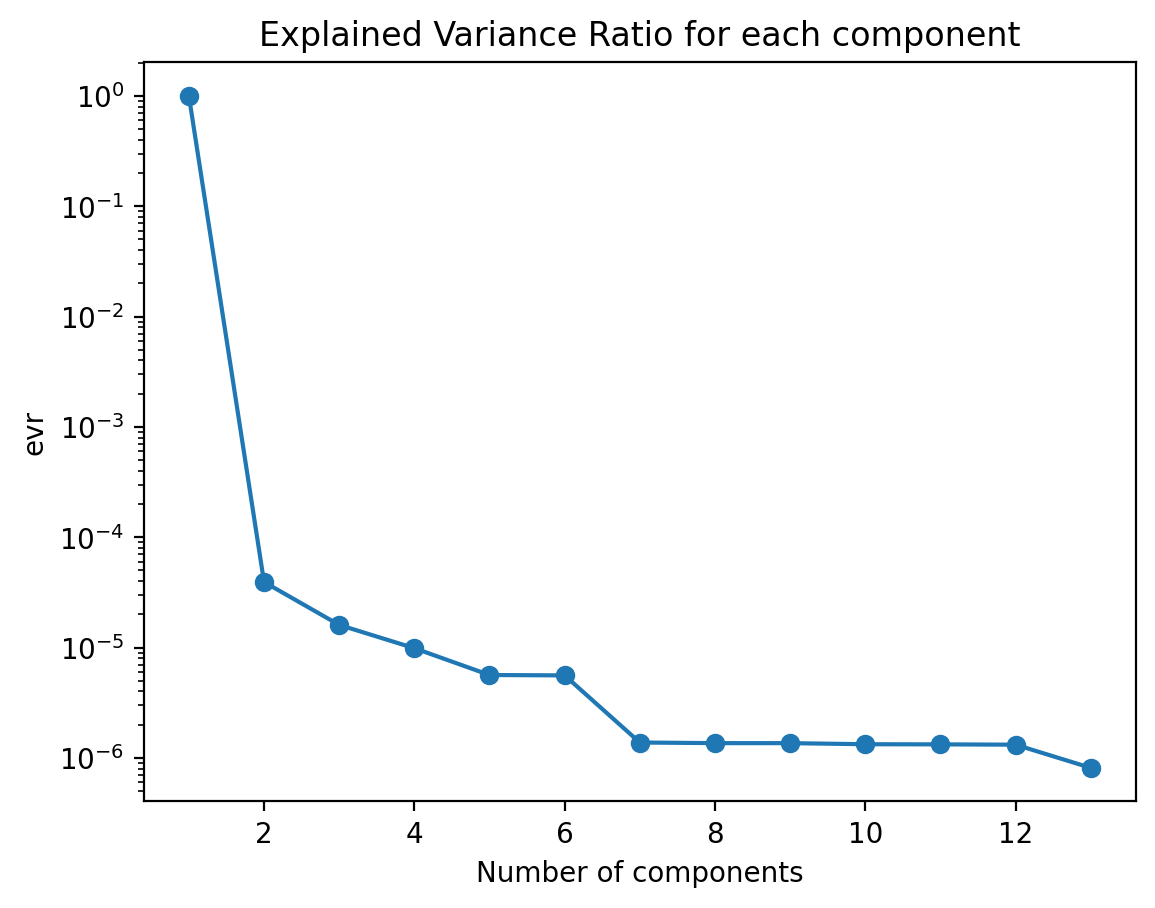

In [39]:
plt.plot(np.arange(1, 14), evals, marker='o')
plt.xlabel('Number of components')
plt.ylabel('evr')
plt.title('Explained Variance Ratio for each component')
plt.yscale('log')

The first component explains more than the $99$% of the variance!!